# Plot validation between BRAN, HYCOM and GLORYS w/ IMOS data

In [2]:
10*10*8500

850000

In [22]:
import dask

dask.config.set(scheduler='processes')


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xray
from datetime import datetime
import pandas as pd
import os

import soda.utils.mysignal as sp
from soda.utils.timeseries import timeseries
from soda.dataio.suntans.sunprofile import Profile
from soda.utils.maptools import ll2utm
from soda.utils.modvsobs import ModVsObs
from soda.dataio import netcdfio
import soda.dataio as io
from soda.utils.myproj import MyProj


#from octant.tools import isoslice
from mycurrents import oceanmooring as om

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

#%matplotlib notebook

Warning - dolfyn not installed. ADCP io not available.


In [2]:
# IMOS station file
#Tfile = '/group/pawsey0106/mrayson/DATA/FIELD/IMOS/IMOS_Gridded_Mooring_T_QC.nc'
#basedir = '/home/suntans/Share'
basedir = '/group/pawsey0106/mrayson'
Tfile = '{}/DATA/FIELD/IMOS/IMOS_Gridded_Mooring_T_QC.nc'.format(basedir)

brandata = '{}/DATA/OCEAN/BRAN2016/BRAN2016_TimorSea_201[2-4]*.nc'.format(basedir)
glorydata = '{}/DATA/OCEAN/GLORYS/GLORYS_NWS_201[2-4]*.nc'.format(basedir)
# SUNTANS profile netcdf file
#sunfile = '../SCENARIOS/OUTPUT_NWS_2km_hex_2013_2014/NWS_2km_hex_2013_2014_Profile.nc'


In [65]:
stationT = 'KIM400_2013_b'
zpoints = np.arange(-400,-20,20) # Use a common grid for model-data comparison

Tobs = om.from_netcdf(Tfile, 'watertemp', group=stationT)

# Filter the data and interpolate onto the common grid
y = Tobs.filt_uneven(34*3600, order=3)
# Subsample and flip the z-dimension
Tobs_f = om.OceanMooring(Tobs.t[::60], y[::-1,::60], Tobs.Z[::-1])

y2 = Tobs_f.interp_z(zpoints, fill_value=0.)
Tobs_fz = om.OceanMooring(Tobs_f.t, y2, zpoints)

(<matplotlib.contour.QuadContourSet at 0x2b313aefb358>,
 <matplotlib.colorbar.Colorbar at 0x2b3137f35400>)

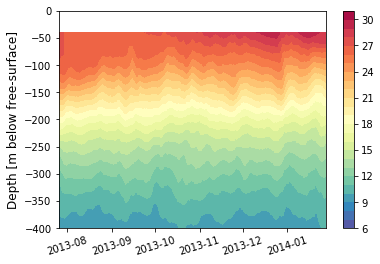

In [66]:
plt.figure()
Tobs_fz.contourf(np.arange(6,32))

In [7]:
ds_bran = xray.open_mfdataset(brandata)
ds_bran

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


<xarray.Dataset>
Dimensions:   (Time: 730, st_ocean: 50, xt_ocean: 350, xu_ocean: 350, yt_ocean: 220, yu_ocean: 220)
Coordinates:
  * xt_ocean  (xt_ocean) float64 107.4 107.6 107.7 107.8 ... 142.1 142.2 142.4
  * yt_ocean  (yt_ocean) float64 -25.05 -24.95 -24.85 ... -3.35 -3.25 -3.15
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.431e+03 2.895e+03 3.603e+03
  * xu_ocean  (xu_ocean) float64 107.5 107.6 107.7 107.8 ... 142.2 142.3 142.4
  * yu_ocean  (yu_ocean) float64 -25.0 -24.9 -24.8 -24.7 ... -3.4 -3.3 -3.2 -3.1
  * Time      (Time) datetime64[ns] 2013-01-01T12:00:00 ... 2014-12-31T12:00:00
Data variables:
    salt      (Time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<shape=(730, 50, 220, 350), chunksize=(1, 50, 220, 350)>
    temp      (Time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<shape=(730, 50, 220, 350), chunksize=(1, 50, 220, 350)>
    u         (Time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<shape=(730, 50, 220, 350), chunksize=(1, 50, 220, 350)>
 

In [12]:
# Grab the nearest BRAN point and convert it to an ocean mooring object
xpt,ypt = float(Tobs.X), float(Tobs.Y)
data_bran = ds_bran['temp'].sel(xt_ocean=xpt, yt_ocean=ypt, method='nearest')
data_bran

<xarray.DataArray 'temp' (Time: 730, st_ocean: 50)>
dask.array<shape=(730, 50), dtype=float32, chunksize=(1, 50)>
Coordinates:
    xt_ocean  float64 121.2
    yt_ocean  float64 -15.25
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.431e+03 2.895e+03 3.603e+03
  * Time      (Time) datetime64[ns] 2013-01-01T12:00:00 ... 2014-12-31T12:00:00
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_potential_temperature
    _ChunkSizes:    [  1   1 300 300]

In [10]:
ds_glory = xray.open_mfdataset(glorydata)
ds_glory

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


<xarray.Dataset>
Dimensions:    (depth: 49, latitude: 277, longitude: 469, time: 1826)
Coordinates:
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 4833.291 5274.784
  * latitude   (latitude) float32 -26.0 -25.916666 ... -3.0833333 -3.0
  * longitude  (longitude) float32 105.0 105.083336 ... 143.91667 144.0
  * time       (time) datetime64[ns] 2011-12-31T12:00:00 ... 2014-07-01T12:00:00
Data variables:
    vo         (time, depth, latitude, longitude) float32 dask.array<shape=(1826, 49, 277, 469), chunksize=(2, 49, 277, 469)>
    thetao     (time, depth, latitude, longitude) float32 dask.array<shape=(1826, 49, 277, 469), chunksize=(2, 49, 277, 469)>
    uo         (time, depth, latitude, longitude) float32 dask.array<shape=(1826, 49, 277, 469), chunksize=(2, 49, 277, 469)>
    so         (time, depth, latitude, longitude) float32 dask.array<shape=(1826, 49, 277, 469), chunksize=(2, 49, 277, 469)>
    zos        (time, latitude, longitude) float32 dask.array<shape=(1826, 2

In [11]:
data_glory = ds_glory['thetao'].sel(longitude=xpt, latitude=ypt, method='nearest')
data_glory

<xarray.DataArray 'thetao' (time: 1826, depth: 49)>
dask.array<shape=(1826, 49), dtype=float32, chunksize=(2, 49)>
Coordinates:
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 4833.291 5274.784
    latitude   float32 -15.25
    longitude  float32 121.083336
  * time       (time) datetime64[ns] 2011-12-31T12:00:00 ... 2014-07-01T12:00:00
Attributes:
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    unit_long:      Degrees Celsius
    cell_methods:   area: mean
    _ChunkSizes:    [  1   7 341 720]

dask.array<getitem, shape=(730, 50), dtype=float32, chunksize=(1, 50)>

In [68]:
T_bran = om.OceanMooring(data_bran.Time.values, data_bran.data[...,::-1], -data_bran.st_ocean.values[::-1], \
                X=data_bran.xt_ocean.values, Y=data_bran.yt_ocean.values, positive='up')

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/dask/array/core.py:1270: FutureWarning: The `numpy.size` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
Process ForkPoolWorker-402:
Traceback (most recent call last):
  File "/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/dask/multiprocessing.py", line 117, in pack_exception
    result = dumps((e, tb))
  File "/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/dask/local.py", line 233, in execute_task
    result = _execute_task(task, data)
  File "/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/dask/core.py", line 118, in _execute_task
    args2 = [_execute_task(a, cache) for a in args]
  File "/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/dask/core.py", line 118, in <listcomp>
    args2 = [_execute_task(a, cache) for 

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
T_glorys = om.OceanMooring(data_glory.time.values, data_glory.data[...,::-1], -data_glory.depth.values[::-1], \
                X=data_glory.longitude.values, Y=data_glory.latitude.values, positive='up')

In [ ]:
# Interpolate the BRAN and glorys data onto the same depth grid
T_bran_z = om.OceanMooring(T_bran.t,  T_bran.interp_z(zpoints, fill_value=0.), T_bran.Z)


In [ ]:
T_glorys_z = om.OceanMooring(T_glorys.t,  T_glorys.interp_z(zpoints, fill_value=0.), T_glorys.Z)


In [ ]:
# Convert to a mod-obs object
mo_bran = ModVsObs(T_bran_z.t, T_bran_z.y, Tobs_fz.t, Tobs_fz.y, \
            Z=zpoint, units='degC', varname='temp')

(<matplotlib.contour.QuadContourSet at 0x2b313caa8c18>,
 <matplotlib.colorbar.Colorbar at 0x2b313ccea208>)

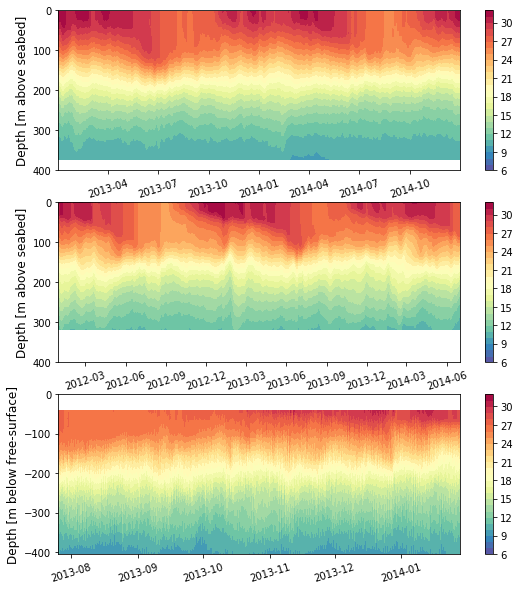

In [35]:
plt.figure(figsize=(9,10))
plt.subplot(311)
T_bran.contourf(np.arange(6,33,1))
plt.ylim(400,0)

plt.subplot(312)
T_glorys.contourf(np.arange(6,33,1))
plt.ylim(400,0)

plt.subplot(313)
Tobs.contourf(np.arange(6,33,1))
#plt.ylim(200,0)

In [ ]:
# Interpolate the GLORYS data

In [29]:
def get_suntans_mo(X,Y, Uobs, sunTS, sunvar, units):
    """
    Get the suntans evuivalent points
    """
    Umod_xray = sunTS(X, Y, -Uobs.Z, sunvar, zinterp='nearest')
    # Convert SUNTANS timeseries to an ocean mooring object
    Umod = om.OceanMooring(Umod_xray.time.values, Umod_xray.values.squeeze(),\
        Uobs.Z, zinterp='linear')

    return ModVsObs(Umod.t, Umod.y, Uobs.t, Uobs.y, \
            Z=Uobs.Z, units=units, varname=sunvar), Umod

def compare_imos_suntans_temp(sunfile, Tfile, stationT, plot=True):
    print(72*'#')
    print('#\t Station: %s'%stationT)
    #print 'Loading the suntans profile...'
    sunTS = Profile(sunfile)
    sunTS
    ##########
    # Load the 400 and 200 m velocity and temperature data
    ##########
    #print 'Loading mooring data...'

    Tobs = om.from_netcdf(Tfile, 'watertemp', group=stationT)
    #Tobs.X, Tobs.Y
    
    # Set the project
    P = MyProj('merc')
    xstation, ystation = P.to_xy(Tobs.X,Tobs.Y)
    #xstation, ystation
    
    #print 'Grabbing suntans points...'
    mo_T, Umod = get_suntans_mo(xstation, ystation, Tobs, sunTS, 'temp', 'degC')
    
    if plot:
        mo_T.printStatsZ()

        # Filter and  Convert to oceanmooring objects
        dsobs = om.OceanMooring(mo_T.TSobs.t, mo_T.TSobs.filt_uneven(34*3600.,order=3), -mo_T.TSobs.Z, positive='down')
        dsmod = om.OceanMooring(mo_T.TSmod.t, mo_T.TSmod.filt_uneven(34*3600.,order=3), -mo_T.TSmod.Z, positive='down')
        ####
        # Plot
        plt.figure(figsize=(8,9))
        ax1=plt.subplot2grid((3,3),(0,0),colspan=3)
        dsobs.contourf(np.arange(7,32,1))
        plt.ylabel('Depth')
        ax1.set_xticklabels([])

        ax2=plt.subplot2grid((3,3),(1,0),colspan=3)
        dsmod.contourf(np.arange(7,32,1))
        plt.ylabel('Depth [m]')


        # Mean temp
        ax3=plt.subplot2grid((3,3),(2,0),colspan=1)
        plt.plot(mo_T.meanMod, mo_T.Z,'ro')
        plt.plot(mo_T.meanObs, mo_T.Z,'bo')
        plt.xlabel('Temperature [$^{\circ}$C]')
        plt.ylabel('Depth [m]')
        plt.grid(b=True)
        plt.xlim([7,30])
        plt.legend(('Mod.','Obs.'), loc='upper left')

        # Bias
        ax4=plt.subplot2grid((3,3),(2,1),colspan=1)
        plt.plot(mo_T.bias, mo_T.Z,'ko')
        plt.xlim(-2.25,2.25)
        ax4.set_xticks([-2,-1,0,1,2])
        ax4.set_yticklabels([])
        plt.xlabel('Bias [$^{\circ}$C]')
        plt.grid(b=True)


        # RMSE
        ax5=plt.subplot2grid((3,3),(2,2),colspan=1)
        plt.plot(mo_T.rmse, mo_T.Z,'ko')
        plt.xlim(-3,3)
        ax5.set_yticklabels([])
        plt.xlabel('RMSE [$^{\circ}$C]')
        plt.grid(b=True)

        plt.tight_layout()
        
        plt.savefig('../FIGURES/IMOS_v_SUNTANS_%s.png'%stationT, dpi=150)
        plt.show()
    
    return mo_T, Umod
